# Modelo de Regresión Múltiple

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

bd5 = bd5.withColumn('Horario1',(bd5.Horario==1) 
).withColumn('Horario2',(bd5.Horario==2) 
).withColumn('Horario3',(bd5.Horario==3))

bd5 = bd5.withColumn('DepDelay2',(bd5.DEP_DELAY**2)
).withColumn('DepD_Distance',(bd5.DEP_DELAY * bd5.DISTANCE)) 

## Descripción Previa de la Base de Datos

Resumen Numérico

In [4]:
pdf5 = bd5.sample(False, 0.1, 0).select('ARR_DELAY','DEP_DELAY','DAY_OF_WEEK',
                                        'CRS_DEP_TIME','DepDelay2','DepD_Distance').toPandas()
pdf5.corr()

,ARR_DELAY,DEP_DELAY,DAY_OF_WEEK,CRS_DEP_TIME,DepDelay2,DepD_Distance
ARR_DELAY,1.000000,0.973316,0.045201,0.100995,0.754650,0.857314
DEP_DELAY,0.973316,1.000000,0.040341,0.096217,0.781235,0.891246
DAY_OF_WEEK,0.045201,0.040341,1.000000,-0.012944,0.028567,0.040694
CRS_DEP_TIME,0.100995,0.096217,-0.012944,1.000000,0.008642,0.058397
DepDelay2,0.754650,0.781235,0.028567,0.008642,1.000000,0.801212
DepD_Distance,0.857314,0.891246,0.040694,0.058397,0.801212,1.000000


Configuración de la Base de Datos

In [5]:
from pyspark.ml.feature import VectorAssembler

a1  = VectorAssembler(
    inputCols=['DEP_DELAY','DISTANCE','DAY_OF_WEEK',
               'CRS_DEP_TIME','Horario1','Horario2',
               'Horario3','DepDelay2','DepD_Distance'],
    outputCol='features')
bd6 = a1.transform(bd5)

In [6]:
from pyspark.sql.functions import col

bd6 = bd6.select(col("ARR_DELAY").alias("label"),'features')
bd6.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|-19.0|[-8.0,236.0,4.0,1...|
|  7.0|[6.0,236.0,4.0,12...|
|-12.0|[-5.0,236.0,4.0,1...|
|-14.0|[-6.0,236.0,4.0,8...|
|-15.0|[-5.0,651.0,4.0,2...|
|  0.0|[-5.0,370.0,4.0,1...|
|-23.0|[-8.0,868.0,4.0,1...|
|-16.0|[-6.0,1464.0,4.0,...|
| -3.0|[-3.0,1464.0,4.0,...|
|  3.0|[-6.0,1055.0,4.0,...|
|-16.0|[-11.0,255.0,4.0,...|
|-11.0|(9,[1,2,3],[1440....|
|  0.0|[1.0,641.0,4.0,22...|
| -4.0|[2.0,1440.0,4.0,1...|
|  3.0|[-9.0,1055.0,4.0,...|
| -7.0|[5.0,1055.0,4.0,1...|
| 18.0|[7.0,370.0,4.0,20...|
|-10.0|[-4.0,1055.0,4.0,...|
|-15.0|[-2.0,1055.0,4.0,...|
|-19.0|[-7.0,1464.0,4.0,...|
+-----+--------------------+
only showing top 20 rows



## Ajuste del modelo

In [7]:
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()
model = lr.fit(bd6)
pred = model.transform(bd6)

/usr/lib/spark/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [8]:
print(model.intercept,model.coefficients)

-4.635889634541887 [1.05553557286,-0.00289488941365,0.135668773288,0.00144922041931,-0.242298226852,1.62235576514,0.159579377181,-1.79458480022e-05,-2.10428631003e-05]


Modelo Predictivo:

$ Y_i = \beta_0 + \beta_1 X_{1i} + ... \beta_p X_{pi} $

In [9]:
pred = pred.withColumn('residual', pred.label-pred.prediction)
pred.show()

+-----+--------------------+-------------------+-------------------+
|label|            features|         prediction|           residual|
+-----+--------------------+-------------------+-------------------+
|-19.0|[-8.0,236.0,4.0,1...|-10.935655853645677| -8.064344146354323|
|  7.0|[6.0,236.0,4.0,12...|  3.482974946599561|  3.517025053400439|
|-12.0|[-5.0,236.0,4.0,1...|-6.9233469005418335|-5.0766530994581665|
|-14.0|[-6.0,236.0,4.0,8...|  -8.26975472757754|  -5.73024527242246|
|-15.0|[-5.0,651.0,4.0,2...| -8.350124376603809| -6.649875623396191|
|  0.0|[-5.0,370.0,4.0,1...| -8.041291554730817|  8.041291554730817|
|-23.0|[-8.0,868.0,4.0,1...|-12.066267226794213|-10.933732773205787|
|-16.0|[-6.0,1464.0,4.0,...|-11.626158499631828| -4.373841500368172|
| -3.0|[-3.0,1464.0,4.0,...| -8.122518253775802|  5.122518253775802|
|  3.0|[-6.0,1055.0,4.0,...| -11.09427815396823|  14.09427815396823|
|-16.0|[-11.0,255.0,4.0,...|-14.001481270182058|-1.9985187298179419|
|-11.0|(9,[1,2,3],[1440....| -5.43

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="rmse").evaluate(pred))
print(RegressionEvaluator(metricName="mae").evaluate(pred))
print(RegressionEvaluator(metricName="r2").evaluate(pred))


15.340617652785491
10.60870150778022
0.917806269789125


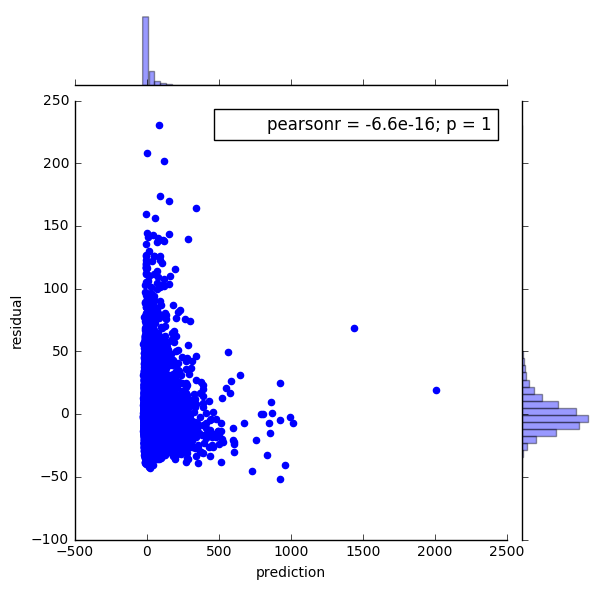

In [11]:
import seaborn as sns
%matplotlib inline

pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="residual", data=pdpred)